# Телеком "Нупозвони"

## Цель исследования

Провести мониторинг клиентов, которые экономически неэффективно используют услуги на своих тарифах, и могут снизить свои расходы, если перейдут на другие тарифы, с более выгодными для них условиями.

## Задачи исследования
- изучить динамику работы клиентов и выделить активных клиентов для проведения расчетов;
- изучить текущую выручку компании (в разрезе месяца), а также динамику за весь период (по тарифам), включая изучение среднего чека в разрезе тарифа;
- определить клиентов, которые неэффективно используют услуги (платят больше, чем могли бы платить на другом тарифе);
- изучить потери в выручке, если все клиенты перейдут на выгодные тарифы;
- предложить пути решения проблемы потери выручки.

## Ход исследования
[Загрузка и обзор данных](#data-review)  
[Предобработка данных](#pre-processing)  
[Исследовательский анализ данных](#analysis)  
[Оптимизация расходов клиентов](#clients)  
[Проверка статистических гипотез](#test)  
[Выводы](#summary)

## Загрузка и обзор данных<a class="anchor" id="data-review"></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from scipy import stats as st

In [2]:
try:
    calls = pd.read_csv('---')
    clients = pd.read_csv('---')
except:
    calls = pd.read_csv('link')
    clients = pd.read_csv('link')

In [3]:
print(calls.info())
print()
print(clients.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    obje

In [4]:
display(calls.head())
display()
display(clients.head())

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


**Датасет `telecom_dataset`**

- `user_id` — идентификатор клиента;
- `date` — дата статистики;
- `direction` — направление вызовов: `out` — исходящий вызов, `in` — входящий;
- `internal` — маркер внутренних и внешних вызовов;
- `operator_id` — идентификатор оператора;
- `is_missed_call` — маркер пропущенных вызовов;
- `calls_count` — количество звонков;
- `call_duration` — длительность звонка без учёта времени ожидания;
- `total_call_duration` — длительность звонка с учётом времени ожидания.

**Датасет `telecom_clients`**

- `user_id` — идентификатор клиента;
- `tariff_plan` — тарифный план клиента;
- `date_start` — дата регистрации клиента в сервисе.

### Правила формирования тарифов

**Ежемесячная плата за тариф:**

- А — 5000 ₽,
- B — 2000 ₽,
- С — 1000 ₽.

**Входящие звонки** — бесплатны на всех тарифах,

**Исходящие звонки внутри сети** — бесплатны до 2000 минут в месяц на всех тарифах. Цена сверх лимита:

- A — 0.1 ₽/мин.,
- B — 0.15 ₽/мин.,
- C — 0.3 ₽/мин.

**Исходящие звонки, кроме внутренних:**

- A — 0.4 ₽/мин.,
- B — 0.5 ₽/мин.,
- C — 0.7 ₽/мин.

За каждого оператора клиент платит 100 ₽ в месяц на любом тарифе — дополнительно к стоимости тарифа и цене звонков.

Оформим тарифную сетку в виде таблицы:

In [5]:
rates = pd.DataFrame({
    'tariff': ['A', 'B', 'C'],
    'monthly': [5000, 2000, 1000],
    'internal_per_minute': [0.1, 0.15, 0.3],
    'internal_free_limit': [2000, 2000, 2000],
    'external_per_minute': [0.4, 0.5, 0.7],
    'monthly_per_operator': [100, 100, 100]
})
rates

,tariff,monthly,internal_per_minute,internal_free_limit,external_per_minute,monthly_per_operator
0,A,5000,0.10,2000,0.4,100
1,B,2000,0.15,2000,0.5,100
2,C,1000,0.30,2000,0.7,100


Было импортировано две базы данных с информацией о звонках (почти 54 тысячи строк) и клиентах (чуть больше 700 строк).  
Также в отдельную таблицу оформлена информация о применяемых тарифах.  
Сразу видно большое количество пропусков в колонке 'operator_id' таблицы calls.

## Предобработка данных<a class="anchor" id="pre-processing"></a>

Для начала определим единицы измерения колонки 'total_call_duration'. Это критически важно так как данная переменная используется для выставления счетов. Посчитаем по дням медианную длительность всех вызовов и разделим на медианное количество операторов обработавших эти вызовы:

In [6]:
calls.groupby('date')['total_call_duration'].sum().median() / calls.groupby('date')['operator_id'].nunique().median()

3406.4651162790697

В день один оператор обработал около 3400 единиц вызовов:
- если предположить что это секнуды: один оператор обработывал 57 минут вызовов в день;
- если предположить что это минуты: один оператор обработывал 57 часов вызовов в день.  

Второй вариант невозможен физически, так что можно утверждать что на данный момент вызовы указаны в секнудах. Переведем в минуты для использования в будущих расчетах.

NB: 57 минут вызовов за день кажется довольно низкой цифрой для 12 часового рабочего дня. Нужно иметь в виду при дальнейшем анализе.

In [7]:
calls['call_duration'] = np.ceil(calls['call_duration']/60).astype(int)
calls['total_call_duration'] = np.ceil(calls['total_call_duration']/60).astype(int)

### Поиск пропусков

In [8]:
print(calls.isna().sum())
print()
print(clients.isna().sum())

user_id                   0
date                      0
direction                 0
internal                117
operator_id            8172
is_missed_call            0
calls_count               0
call_duration             0
total_call_duration       0
dtype: int64

user_id        0
tariff_plan    0
date_start     0
dtype: int64


In [9]:
calls[calls['internal'].isna()].head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
1007,166405,2019-09-18 00:00:00+03:00,in,NaN,NaN,True,1,0,1
1090,166405,2019-10-01 00:00:00+03:00,in,NaN,NaN,True,1,0,1
1864,166406,2019-08-20 00:00:00+03:00,in,NaN,NaN,True,1,0,1
1924,166406,2019-09-02 00:00:00+03:00,in,NaN,879898.0,False,1,1,1
6210,166541,2019-09-26 00:00:00+03:00,in,NaN,908960.0,False,1,7,8


In [10]:
for column in calls.columns:
    if calls[column].isna().sum() > 0:
        ratio_isna = calls[column].isna().sum() / len(calls[column])
        print(f'Доля пропущенных значений в столбце {column}: {ratio_isna:.2%}')

Доля пропущенных значений в столбце internal: 0.22%
Доля пропущенных значений в столбце operator_id: 15.16%


Больше всего пропусков в колонке с айди оператора: больше 15% строк. Проверим параметры вызовов с пропущенными операторами:

In [11]:
(calls[calls['operator_id'].isna()]
 .groupby(['is_missed_call','direction','internal'])
 .agg({'user_id':'nunique','calls_count':'sum','total_call_duration':'sum'})
 .assign(calls_share = lambda x: x['calls_count'] / calls[calls['operator_id'].isna()].calls_count.sum())
)

user_id  calls_count  total_call_duration  \
is_missed_call direction internal                                              
False          in        False          10          704                 5967   
                         True            1           10                   18   
               out       False           3          325                 3182   
                         True            2            9                   19   
True           in        False         303       111295                26863   
                         True           76          995                  509   
               out       False          37          153                   31   
                         True           14           56                   21   

                                   calls_share  
is_missed_call direction internal               
False          in        False        0.006191  
                         True         0.000088  
               out       False        0.002858  
                         True         0.000079  
True           in        False        0.978710  
                         True         0.008750  
               out       False        0.001345  
                         True         0.000492

Подавляющее большинство строк без оператора (почти 98%) содержат информацию о пропущенных внешних входящих выховах, то есть оператор не был назначен на поступащий в колл-центр звонок. Например, потому что все операторы были заняты. Такие пропуски не тарифицируются и не повлияют на расчет выручки, поэтому заменим для них номер оператора на нули, чтобы в дальнейшем изменить тип данных на целочисленный.

Пропуски в колонке направления звонка влияют на расчет тарифа, но их невозможно восставновить на основе других данных. Так как их очень мало просто удалим эти строки.

In [12]:
calls['operator_id'] = calls['operator_id'].fillna(0)
calls.dropna(subset=['internal'], inplace=True)

In [13]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53785 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53785 non-null  int64  
 1   date                 53785 non-null  object 
 2   direction            53785 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          53785 non-null  float64
 5   is_missed_call       53785 non-null  bool   
 6   calls_count          53785 non-null  int64  
 7   call_duration        53785 non-null  int64  
 8   total_call_duration  53785 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.7+ MB


### Поиск дубликатов

In [14]:
print('calls:', calls.duplicated().sum())
print()
print('clients:', clients.duplicated().sum())

calls: 4893

clients: 0


In [15]:
calls[calls.duplicated()].head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
8,166377,2019-08-05 00:00:00+03:00,out,False,880020.0,True,8,0,1
28,166377,2019-08-12 00:00:00+03:00,in,False,0.0,True,2,0,1
44,166377,2019-08-14 00:00:00+03:00,out,False,880026.0,False,10,27,28
45,166377,2019-08-14 00:00:00+03:00,in,False,0.0,True,1,0,1
51,166377,2019-08-15 00:00:00+03:00,out,False,880026.0,False,11,24,25


In [16]:
calls[calls.duplicated()]['internal'].value_counts()

False    4382
True      511
Name: internal, dtype: int64

Почти все дубликаты -- внешние звонки. На данном этапе нет возможности утверждать откуда они берутся.  
Чтобы не искажать результаты анализа отбросим все дубликаты.

In [17]:
calls = calls.drop_duplicates()

### Изменение типов данных 

In [18]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48892 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              48892 non-null  int64  
 1   date                 48892 non-null  object 
 2   direction            48892 non-null  object 
 3   internal             48892 non-null  object 
 4   operator_id          48892 non-null  float64
 5   is_missed_call       48892 non-null  bool   
 6   calls_count          48892 non-null  int64  
 7   call_duration        48892 non-null  int64  
 8   total_call_duration  48892 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.4+ MB


In [19]:
calls['internal'] = calls['internal'].astype('bool', errors='ignore')
calls['operator_id'] = calls['operator_id'].astype('int32')

In [20]:
calls['date'] = pd.to_datetime(calls['date'], format='%Y-%m-%d %H:%M:%S')
clients['date_start'] = pd.to_datetime(clients['date_start'], format='%Y-%m-%d')

In [21]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48892 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype                                
---  ------               --------------  -----                                
 0   user_id              48892 non-null  int64                                
 1   date                 48892 non-null  datetime64[ns, pytz.FixedOffset(180)]
 2   direction            48892 non-null  object                               
 3   internal             48892 non-null  bool                                 
 4   operator_id          48892 non-null  int32                                
 5   is_missed_call       48892 non-null  bool                                 
 6   calls_count          48892 non-null  int64                                
 7   call_duration        48892 non-null  int64                                
 8   total_call_duration  48892 non-null  int64                                
dtypes: bool

In [22]:
calls.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,0,True,2,0,1
1,166377,2019-08-05 00:00:00+03:00,out,True,880022,True,3,0,1
2,166377,2019-08-05 00:00:00+03:00,out,True,880020,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020,False,1,1,1
4,166377,2019-08-05 00:00:00+03:00,out,False,880022,True,3,0,1


Добавим колонку с месяцем для удобства группировки:

In [23]:
calls['month'] = calls['date'].dt.to_period('M')

/Users/aksyutenko/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/datetimes.py:1143: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


В ходе предобработки данных: 
- определены единицы измерения длительности звонков в базе данных и переведены в минуты для удобства дальнейших расчетов;
- большинство пропусков содержится в столбце 'operator_id' и не влияет на расчет выручки, так как относится в подавляющей части ко входящим вызовам;
- дубликаты удалены, на данный момент нет возможности высянить причину их появления;
- изменены типы данных где это необходимо.

## Исследовательский анализ данных<a class="anchor" id="analysis"></a>

### Исследование диапазона значений

In [24]:
print(calls['date'].min())
print(calls['date'].max())

2019-08-02 00:00:00+03:00
2019-11-28 00:00:00+03:00


In [25]:
print('Уникальных клиентов в датафрейме clients:', clients['user_id'].nunique())
print('Уникальных клиентов в датафрейме calls:', calls['user_id'].nunique())
print('Уникальных операторов:', calls['operator_id'].nunique())

Уникальных клиентов в датафрейме clients: 732
Уникальных клиентов в датафрейме calls: 307
Уникальных операторов: 1093


Больше половины клиентов из нашей базы данных вообще не пользовались услугами за анализируемый период. Очевидно, что нет смысла предлагать им переход на другой тариф.

Посмотрим на распределение тарифов среди пользователей:

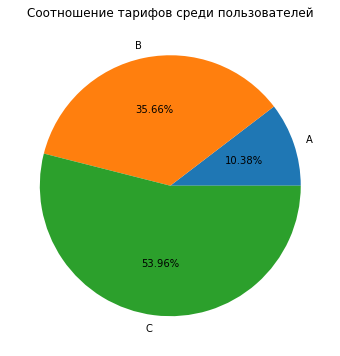

In [26]:
fig,ax = plt.subplots(figsize=(6, 6))
ax.pie(clients.groupby('tariff_plan')['user_id'].count(), 
       labels=clients.groupby('tariff_plan')['user_id'].count().index,
       autopct='%.2f%%')
ax.set_title('Соотношение тарифов среди пользователей')
plt.show()

Большинство использует тариф С, с минимальной фиксированной платой.

Проверим меняли ли пользователи тариф за текущий период:

In [27]:
clients['user_id'].value_counts().sort_values()

166713    1
168361    1
168527    1
167097    1
168193    1
         ..
166702    1
166554    1
166911    1
166867    1
166565    1
Name: user_id, Length: 732, dtype: int64

Никто из клиентов не менял тариф за выбранный период.

Построим графики динамики использования услуг клиентами:

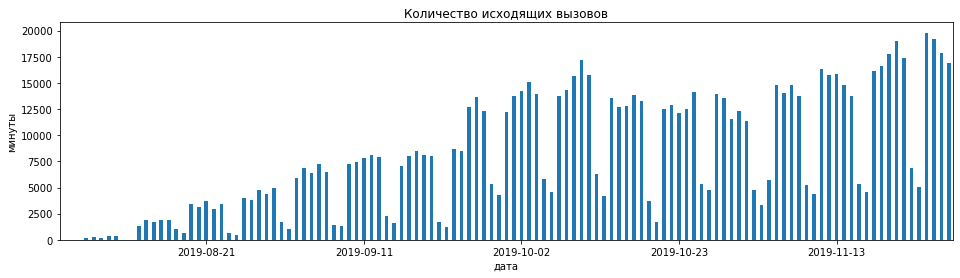

In [28]:
df = (calls[calls['internal'] == False]
 .sort_values('date')
 .groupby('date')['total_call_duration']
 .sum()
 .reset_index())

df['date'] = df['date'].dt.to_period('D')

ax = df.plot(x='date', y='total_call_duration', kind='bar', figsize=(16,4))

ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=3))
ax.set(title='Количество исходящих вызовов')
ax.set_xlabel('дата')
ax.set_ylabel('минуты')
plt.xticks(rotation = 0)
ax.get_legend().remove()
plt.show()

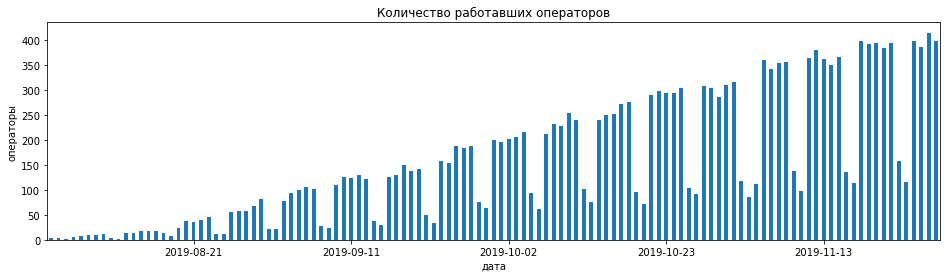

In [29]:
df = (calls[calls['internal'] == False]
 .sort_values('date')
 .groupby('date')['operator_id'].nunique()
 .reset_index())
 
df['date'] = df['date'].dt.to_period('D')

ax = df.plot(x='date', y='operator_id', kind='bar', figsize=(16,4))

ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=3))
ax.set(title='Количество работавших операторов')
ax.set_xlabel('дата')
ax.set_ylabel('операторы')
plt.xticks(rotation = 0)
ax.get_legend().remove()
plt.show()

Из двух графиков видно постепенное нарастание количества минут и операторов в течение всего периода. Возможно это связано с сезонностью, либо есть другие особенности работы компании или данных в выгрузке. Также видна недельная цикличность: паттерн поторяется примерно каждые семь дней.

Также неизвестна система назначения айди для операторов. Действительно ли штат операторов увеличился в несколько раз или есть система назначения айди при которой у одного опертора несколько айди? Например, для разделения затрат между пользователями.

Количество пользователей растет примерно до середины октября:

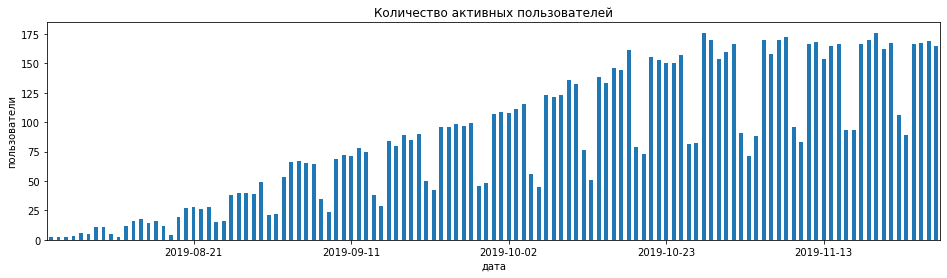

In [30]:
df = (calls[calls['internal'] == False]
 .sort_values('date')
 .groupby('date')['user_id'].nunique()
 .reset_index())

df['date'] = df['date'].dt.to_period('D')

ax = df.plot(x='date', y='user_id', kind='bar', figsize=(16,4))

ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=3))
ax.set(title='Количество активных пользователей')
ax.set_xlabel('дата')
ax.set_ylabel('пользователи')
plt.xticks(rotation = 0)
ax.get_legend().remove()
plt.show()

При этом приток новых пользователей довольно стабильный:

array([[<AxesSubplot:title={'center':'date_start'}>]], dtype=object)

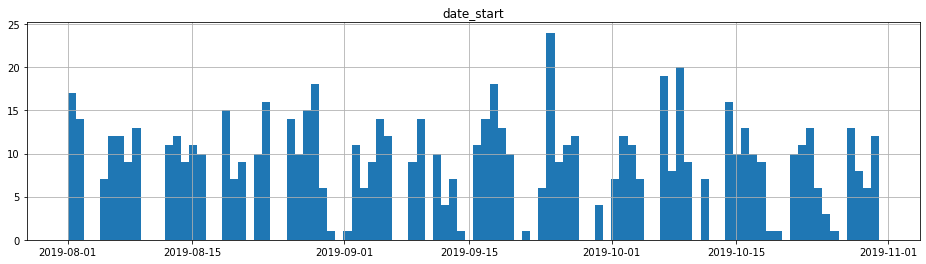

In [31]:
clients.hist('date_start', bins=100, figsize=(16,4))

Компания наращивает обороты практически с нуля. Это может быть вызвано особоенностью выборки, сезонностью или недавним началом деятельности компании.

### Поиск и устранение аномалий

По сообщению от заказчика, у некоторых колл-центров за отчетный период был сбой системы распределения звонков и все звонки записывались на одного из операторов. Проверим распрделение нагрузки по пользователям и операторам.

In [32]:
calls.groupby('user_id')['total_call_duration'].sum().sort_values(ascending=False).head(10)

user_id
166582    197627
168361     95158
167626     78093
166658     43628
168252     33689
168187     27447
166405     24702
167827     22251
167125     19087
168062     18396
Name: total_call_duration, dtype: int64

In [33]:
(calls
 .groupby('operator_id')['total_call_duration'].sum()
 .sort_values(ascending=False)
 .head())

operator_id
885876    95690
885890    79860
0         33796
925922    20917
929428    10586
Name: total_call_duration, dtype: int64

Пользователь 166582 и операторы 885876, 885890 и 925922 явно выбиваются из общей картины. Проверим сколько часов в день работали эти операторы и какие операторы обслаживали пользователя 166582:

In [34]:
top5_operators = (calls
                  .groupby('operator_id')['total_call_duration'].sum()
                  .sort_values(ascending=False)
                  .head()
                  .reset_index()['operator_id'])

for o in top5_operators:
    min_per_day = calls[calls['operator_id'] == o]['total_call_duration'].sum() / calls[calls['operator_id'] == o]['date'].nunique()
    print(f'Оператор {o}: {min_per_day/60:.2f}')

Оператор 885876: 16.44
Оператор 885890: 16.64
Оператор 0: 4.73
Оператор 925922: 14.53
Оператор 929428: 5.35


Первые три оператора сильно выделяются, с физически невозможным количеством часов в день.

In [35]:
calls.query('user_id == 166582').pivot_table(index='user_id',
                                        columns='operator_id',
                                        values='total_call_duration',
                                        aggfunc='sum')

operator_id,0,885876,885890,925922
user_id,,,,
166582,1160,95690,79860,20917


Судя по всему именно на эти три айди операторов записывались все звонки пользователя 166582. Посмотрим распределение по месяцам:

In [36]:
(calls.query('user_id == 166582')
 .pivot_table(index='operator_id',
              columns='month',
              values='total_call_duration',
              aggfunc='sum'))

month,2019-08,2019-09,2019-10,2019-11
operator_id,,,,
0,125.0,593.0,417.0,25.0
885876,12517.0,53571.0,28025.0,1577.0
885890,19463.0,31791.0,28606.0,NaN
925922,NaN,NaN,20917.0,NaN


Удостоверимся что эти операторы работали только с одним пользователем.

In [37]:
(calls
 .query('operator_id in [885876, 885890, 925922]')
 .pivot_table(index='operator_id',
             columns='user_id',
             values='total_call_duration',
             aggfunc='sum'))

user_id,166582
operator_id,
885876,95690
885890,79860
925922,20917


In [38]:
calls.query('user_id == 166582')['total_call_duration'].sum() / calls['total_call_duration'].sum() * 100

20.38204933308444

Звонки пользователя 166582 составляют больше 20% от всех учтенных за анализируемый период! Просто избавиться от этих данных будет неправильно, так как мы не учтём очень большую часть выручки.

Рассчитаем медианное значение длительности вызовов которое оператор обрабатывает за день. На основе этого числа посчитаем какое количество операторов смогли бы обработать вызовы пользователя 166582.

In [39]:
calls.groupby('operator_id')['total_call_duration'].sum().describe()

count     1093.000000
mean       887.111619
std       4115.974336
min          0.000000
25%         13.000000
50%        123.000000
75%        776.000000
max      95690.000000
Name: total_call_duration, dtype: float64

In [40]:
new_calls = calls.query('operator_id not in [885876, 885890, 925922]')
new_calls.groupby('operator_id')['total_call_duration'].sum().describe()

count     1090.000000
mean       709.308257
std       1614.864030
min          0.000000
25%         13.000000
50%        122.500000
75%        770.000000
max      33796.000000
Name: total_call_duration, dtype: float64

Так как аномальный пользователь у нас лишь один, он не сильно влияет на статистику, только значительно смещает среднее при группировке по операторам.

Посчитаем количество минут в день для каждого оператора и количество отработанных дней. Далее используме 75й перцентиль у топ-10 пользователей для того чтобы посчитать теоритическое количество операторов, которые могли обработать вызовы самого крупного из наших пользователей.

In [41]:
# считаем количество минут и количество рабочих для каждого оператора

time_per_day = (calls[calls['operator_id'] != 0]
 .pivot_table(index='operator_id',
              values=['total_call_duration', 'date'],
              aggfunc={'total_call_duration':'sum', 'date':pd.Series.nunique})
 .reset_index()
 .sort_values(by='total_call_duration', ascending=False)
 .fillna(0))

# считаем среднее количество отработанных минут в день для каждого оператора

for i in range(len(time_per_day)):
    time_per_day.loc[i, 'minutes_per_day'] = time_per_day.loc[i, 'total_call_duration'] / time_per_day.loc[i, 'date']
    
time_per_day.head(10)

,operator_id,date,total_call_duration,minutes_per_day
28,885876,97,95690,986.494845
29,885890,80,79860,998.250000
551,925922,24,20917,871.541667
583,929428,33,10586,320.787879
958,952948,26,8261,317.730769
203,901880,88,8199,93.170455
582,929426,32,7932,247.875000
853,945302,35,7688,219.657143
12,882686,80,7301,91.262500
368,913938,65,7070,108.769231


In [42]:
"""
считаем медианное количество минут в день для топ-10 операторов
которые работали меньше 12 часов в день (720 минут)
"""
median_time = (time_per_day
               # счиатем только по операторам без аномально высоких значений времени работы
               .query('minutes_per_day < 720')['minutes_per_day']
               # считаем медианное время для топ-10 операторов
               .head(10)
               .median())
median_time

233.76607142857142

In [43]:
"""
посчитаем максимальное количество операторов
которые могли обработать вызовы пользователя 166582
в соответствии с рассчитанным медианным временем
"""
new_operators = (calls
                 .query('user_id == 166582')
                 .groupby(['month','date'])
                 .agg({'total_call_duration':'sum'})
                 # по медианному времени для топ-10 операторов:
                 .assign(n_operators = lambda x: np.ceil(x['total_call_duration'] / median_time))
                 .groupby(['month'])
                 .agg({'n_operators':'max'})
                 .reset_index())

new_operators['n_operators'] = new_operators['n_operators'].astype('int32')

new_operators

,month,n_operators
0,2019-08,12
1,2019-09,20
2,2019-10,21
3,2019-11,1


### Анализ динамики использоавния услуг и выделение активных клиентов

Для расчета выручки выделим только тарифицируемые звонки, то есть исходящие:

In [44]:
rated_calls = calls[(calls['direction'] == 'out')]
rated_calls.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,month
1,166377,2019-08-05 00:00:00+03:00,out,True,880022,True,3,0,1,2019-08
2,166377,2019-08-05 00:00:00+03:00,out,True,880020,True,1,0,1,2019-08
3,166377,2019-08-05 00:00:00+03:00,out,True,880020,False,1,1,1,2019-08
4,166377,2019-08-05 00:00:00+03:00,out,False,880022,True,3,0,1,2019-08
5,166377,2019-08-05 00:00:00+03:00,out,False,880020,False,2,1,1,2019-08


Для каждого пользователя посчитаем помесячное количество, исходящих и входящих минут и далее объединим в одну таблицу:

In [45]:
operators = (calls
             .query('operator_id != 0')
             .pivot_table(index=['user_id', 'month'],
                                    values='operator_id',
                                    aggfunc=pd.Series.nunique))
operators.head()

operator_id
user_id month               
166377  2019-08            5
        2019-09            4
        2019-10            5
        2019-11            4
166391  2019-08            2

In [46]:
internal = (calls
            .query('internal == True & direction == "out"')
            .pivot_table(index=['user_id', 'month'],
                         values='total_call_duration',
                         aggfunc='sum'))
internal.head()

total_call_duration
user_id month                       
166377  2019-08                    8
        2019-09                    5
        2019-10                    2
        2019-11                    4
166391  2019-08                    1

In [47]:
external = (calls
            .query('internal == False & direction == "out"')
            .pivot_table(index=['user_id', 'month'],
                         values='total_call_duration',
                         aggfunc='sum'))
external.head()

total_call_duration
user_id month                       
166377  2019-08                 1337
        2019-09                 1818
        2019-10                 1704
        2019-11                 1633
166405  2019-08                  875

In [48]:
user_revenue = (pd.concat([operators, internal, external], axis=1)
                .reset_index()
                .set_axis(['user_id',
                           'month',
                           'operators',
                           'internal',
                           'external'], axis=1)
                .fillna({'internal':0,'external':0})
                .astype({'operators':'int32',
                         'internal':'int32',
                         'external':'int32'},
                        errors='ignore')
                .merge(clients[['user_id','tariff_plan']],
                       on=['user_id']))
user_revenue.head()

,user_id,month,operators,internal,external,tariff_plan
0,166377,2019-08,5,8,1337,B
1,166377,2019-09,4,5,1818,B
2,166377,2019-10,5,2,1704,B
3,166377,2019-11,4,4,1633,B
4,166391,2019-08,2,1,0,C


In [49]:
user_revenue.loc[user_revenue['user_id'] == 166582, 'operators'] = new_operators['n_operators'].tolist()
user_revenue['operators'] = user_revenue['operators'].astype('int32')
user_revenue[user_revenue['user_id'] == 166582]

,user_id,month,operators,internal,external,tariff_plan
66,166582,2019-08,12,1,31410,A
67,166582,2019-09,20,0,84136,A
68,166582,2019-10,21,0,75993,A
69,166582,2019-11,1,0,1564,A


Удостоверимся что нигде не потеряли драгоценные минуты:

In [50]:
print(calls.query('direction == "out"')['total_call_duration'].sum())
print(external['total_call_duration'].sum() + internal['total_call_duration'].sum())

753395
753395


In [51]:
user_revenue['internal'].sort_values(ascending=False).head()

457    1540
226    1459
622     755
616     653
341     486
Name: internal, dtype: int32

Никто из пользователей в течение анализируемого периода не использовал больше 2000 внутренних вызовов, а значит для выделения активных пользователей этой метрикой можно пренебречь и сконцентрироваться на внешних вызовах. Тем более именно они приносят основную выручу.

*Также можно предположить что количество операторов определяется нагрузкой на колл-центр, то есть первичной метрикой является именно количество минут. Поэтому для выделения активных пользователей будем использовать именно эту метрику.*

Посмотрим на распрделение внешних минут среди пользователей разных тарифов:

In [52]:
for tariff in rates['tariff'].unique():
    mean = 0
    variance = 0
    std = 0
    mean = user_revenue.query('tariff_plan == @tariff')['external'].mean()
    variance = np.var(user_revenue.query('tariff_plan == @tariff')['external'])
    std = np.sqrt(variance)
    print(f'Тариф {tariff}')
    print(f'Среднее количество исходящих минут: {mean:.2f}')
    print(f'Дисперсия: {variance:.2f}')
    print(f'Cтандартное отклонение: {std:.2f}')
    print()

Тариф A
Среднее количество исходящих минут: 5256.34
Дисперсия: 257496722.20
Cтандартное отклонение: 16046.70

Тариф B
Среднее количество исходящих минут: 596.14
Дисперсия: 2146478.10
Cтандартное отклонение: 1465.09

Тариф C
Среднее количество исходящих минут: 437.42
Дисперсия: 1708044.90
Cтандартное отклонение: 1306.92



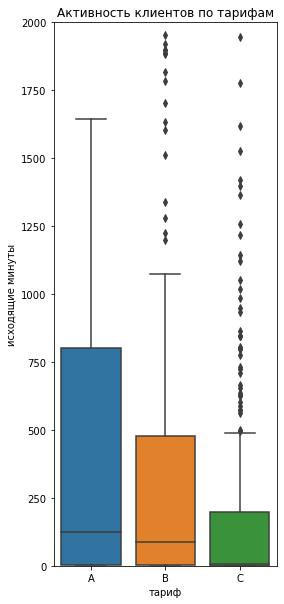

In [53]:
plt.figure(figsize = [4,10])
ax = sns.boxplot(data = user_revenue, x = 'tariff_plan', y = 'external', order = rates['tariff'])
ax.set(title='Активность клиентов по тарифам')
ax.set_xlabel('тариф')
ax.set_ylabel('исходящие минуты')
plt.ylim(0,2000)
plt.show()

Рост активности довольно равномерный от тарифа к тарифу.

Для выделения активных пользователей используем медиану исходящих минут по всем пользователям:

In [54]:
active_users = user_revenue[user_revenue['external'] > user_revenue['external'].median()]['user_id'].unique()

In [55]:
print('Уникальных клиентов в датафрейме clients:', clients['user_id'].nunique())
print('Уникальных клиентов в датафрейме calls:', calls['user_id'].nunique())
print('Уникальных активных клиентов:', len(active_users))

Уникальных клиентов в датафрейме clients: 732
Уникальных клиентов в датафрейме calls: 307
Уникальных активных клиентов: 161


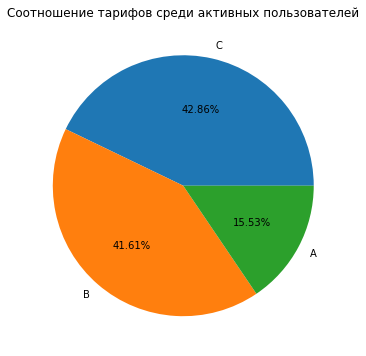

In [56]:
fig,ax = plt.subplots(figsize=(6, 6))
ax.pie(clients.query('user_id in @active_users')['tariff_plan'].value_counts(), 
       labels=clients.query('user_id in @active_users')['tariff_plan'].value_counts().index,
       autopct='%.2f%%')
ax.set_title('Соотношение тарифов среди активных пользователей')
plt.show()

### Анализ выручки (за месяц и весь период) + средний чек

In [57]:
rates

,tariff,monthly,internal_per_minute,internal_free_limit,external_per_minute,monthly_per_operator
0,A,5000,0.10,2000,0.4,100
1,B,2000,0.15,2000,0.5,100
2,C,1000,0.30,2000,0.7,100


In [58]:
user_revenue.head()

,user_id,month,operators,internal,external,tariff_plan
0,166377,2019-08,5,8,1337,B
1,166377,2019-09,4,5,1818,B
2,166377,2019-10,5,2,1704,B
3,166377,2019-11,4,4,1633,B
4,166391,2019-08,2,1,0,C


In [59]:
def revenue_calc(row):
    month_revenue = 0
    
    # Считаем разницу между потраченными минутами и объемом услуг, включенных в абонентскую плату:
    delta_internal_calls = row['internal'] - int(rates[rates['tariff'] == row['tariff_plan']]['internal_free_limit']) 
    
    if delta_internal_calls > 0:
        month_revenue += row['internal'] * float(rates[rates['tariff'] == row['tariff_plan']]['internal_per_minute'])
   
    # прогоняем расчет основной выручки в зависимости от тарифа:
    month_revenue += row['external'] * float(rates[rates['tariff'] == row['tariff_plan']]['external_per_minute'])
    month_revenue += row['operators'] * int(rates[rates['tariff'] == row['tariff_plan']]['monthly_per_operator'])
    month_revenue += int(rates[rates['tariff'] == row['tariff_plan']]['monthly'])
    
    row['revenue'] = month_revenue  
    return row

In [60]:
user_revenue = user_revenue.apply(revenue_calc, axis=1)
display(user_revenue.head(2))
user_revenue.groupby('tariff_plan')['revenue'].sum()

,user_id,month,operators,internal,external,tariff_plan,revenue
0,166377,2019-08,5,8,1337,B,3168.5
1,166377,2019-09,4,5,1818,B,3309.0


tariff_plan
A    644208.0
B    653416.0
C    554760.6
Name: revenue, dtype: float64

Построим несколько графиков для визуализации динамики выручки по тарифам:

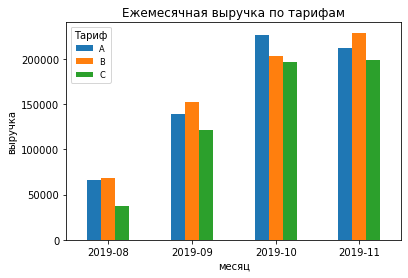

In [61]:
ax = (user_revenue
 .pivot_table(index='month',
              values='revenue',
              columns='tariff_plan',
              aggfunc='sum')
 .reset_index()
 .plot(x='month', y=['A', 'B', 'C'], kind="bar")
)
ax.set(title='Ежемесячная выручка по тарифам')
ax.set_xlabel('месяц')
ax.set_ylabel('выручка')
plt.xticks(rotation = 0)
plt.legend(title='Тариф', fontsize='small')
plt.show()

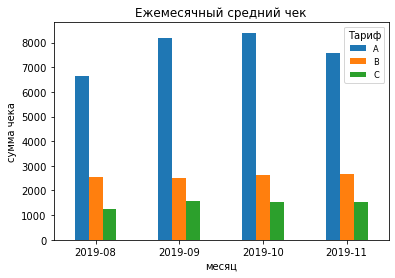

In [62]:
ax = (user_revenue
      .pivot_table(index='month',
                   columns='tariff_plan',
                   values='revenue',
                   aggfunc='mean')
      .reset_index()
      .plot(x='month', y=['A', 'B', 'C'], kind="bar"))
ax.set(title='Ежемесячный средний чек')
ax.set_xlabel('месяц')
ax.set_ylabel('сумма чека')
plt.xticks(rotation = 0)
plt.legend(title='Тариф', fontsize='small')
plt.show()

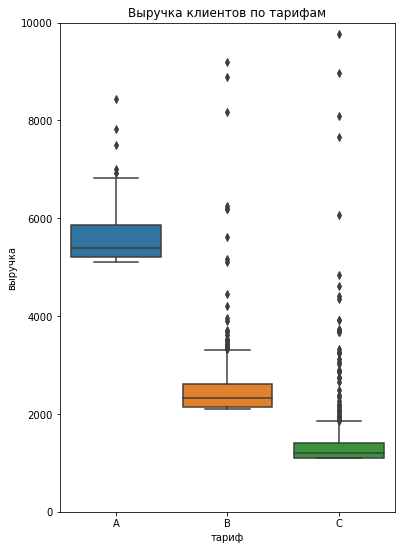

In [63]:
plt.figure(figsize = [6,9])
ax = sns.boxplot(data = user_revenue, x = 'tariff_plan', y = 'revenue', order = rates['tariff'])
ax.set(title='Выручка клиентов по тарифам')
ax.set_xlabel('тариф')
ax.set_ylabel('выручка')
plt.ylim(0,10000)
plt.show()

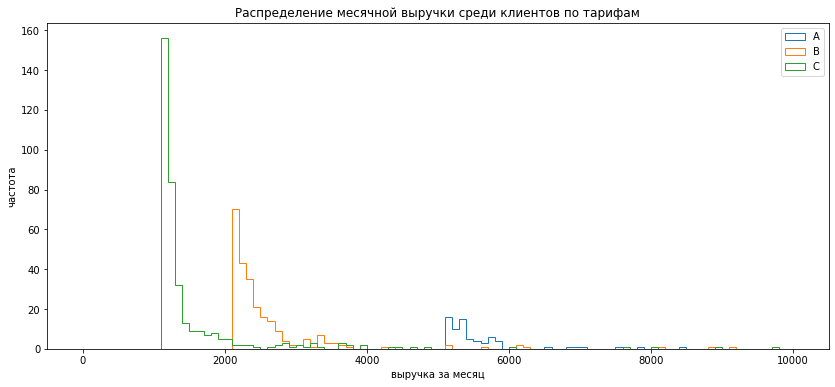

In [64]:
plt.figure(figsize=(14,6))
for tariff, val in user_revenue.groupby(by='tariff_plan'):
    ax = plt.hist(val['revenue'], histtype='step', label=tariff, linewidth=1, bins=100, range=(0,10000))
plt.legend()
plt.title('Распределение месячной выручки среди клиентов по тарифам')
plt.xlabel('выручка за месяц')
plt.ylabel('частота')
plt.show()

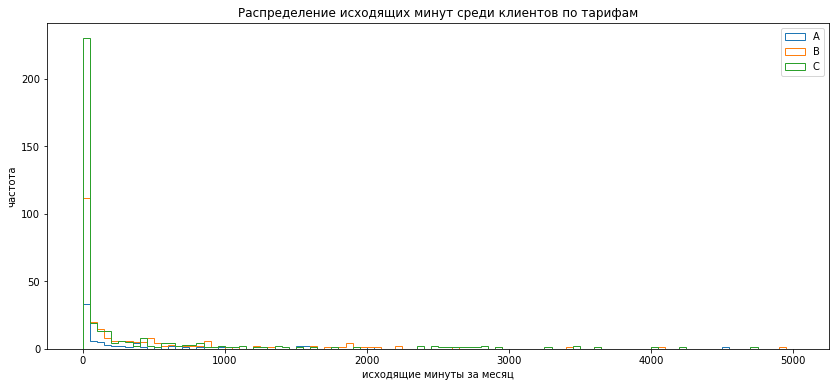

In [65]:
plt.figure(figsize=(14,6))
for tariff, val in user_revenue.groupby(by='tariff_plan'):
    plt.hist(val['external'], histtype='step', label=tariff, linewidth=1, bins=100, range=(0,5000))
plt.legend()
plt.title('Распределение исходящих минут среди клиентов по тарифам')
plt.xlabel('исходящие минуты за месяц')
plt.ylabel('частота')
plt.show()

In [66]:
for tariff in rates['tariff'].unique():
    mean = 0
    variance = 0
    std = 0
    mean = user_revenue[user_revenue['tariff_plan'] == tariff]['revenue'].mean()
    variance = np.var(user_revenue[user_revenue['tariff_plan'] == tariff]['revenue'])
    std = np.sqrt(variance)
    print(f'Тариф {tariff}')
    print(f'Средний месячный чек: {mean:.2f}')
    print(f'Дисперсия: {variance:.2f}')
    print(f'Cтандартное отклонение: {std:.2f}')
    print()

Тариф A
Средний месячный чек: 7856.20
Дисперсия: 49894026.53
Cтандартное отклонение: 7063.57

Тариф B
Средний месячный чек: 2603.25
Дисперсия: 897995.94
Cтандартное отклонение: 947.63

Тариф C
Средний месячный чек: 1519.89
Дисперсия: 1018948.23
Cтандартное отклонение: 1009.43



По резульататам исследовательского анализа данных можно сделать выводы:
- В среднем пользователи более дорогих тарифов больше ползуются услугами (больше исходящих внешних вызовов);
- Выделены активные клиенты (с длительностью исходящих вызовов больше медианной), всего 161 клиент;
- Средняя выручка по месяцам довольно равномерно распрделеная среди тарифов. Меньшее количество более дорогих тарифов тратят больше, а пользователи тарифа С берут количеством;
- Средний чек по тарифу А значительно превышает остальные тарифы.

## Оптимизация расходов клиентов<a class="anchor" id="clients"></a>

### Анализ расходов клиентов неэффективно использующих услуги и подбор оптимального тарифного плана для снижения расходов

In [67]:
def optimal_revenue_calc(row):
    
    # считаем выручку по каждому тарифу, который у нас есть в базе:
    revenue_var = {}
    for i in list(rates['tariff'].unique()):
        tariff_name = str(i)
        
        revenue = 0
        
        # считаем разницу между потраченными минутами и объемом услуг, включенных в абонентскую плату:
        delta_internal_calls = row['internal'] - int(rates[rates['tariff'] == tariff_name]['internal_free_limit'])     
        if delta_internal_calls > 0:
            revenue += row['internal'] * float(rates[rates['tariff'] == tariff_name]['internal_per_minute'])
        revenue += row['operators'] * int(rates[rates['tariff'] == tariff_name]['monthly_per_operator'])
        revenue += row['external'] * float(rates[rates['tariff'] == tariff_name]['external_per_minute'])
        revenue += int(rates[rates['tariff'] == tariff_name]['monthly'])
        # записываем выручку по каждому тарифу в отдельный столбец
        row['revenue_' + str(i)] = revenue
    
    return row

user_revenue = user_revenue.apply(optimal_revenue_calc, axis=1)
display(user_revenue.head(2))

,user_id,month,operators,internal,external,tariff_plan,revenue,revenue_A,revenue_B,revenue_C
0,166377,2019-08,5,8,1337,B,3168.5,6034.8,3168.5,2435.9
1,166377,2019-09,4,5,1818,B,3309.0,6127.2,3309.0,2672.6


In [68]:
# считаем оптимальную выручку для каждого месяца

for i in range(len(user_revenue)):
    if (user_revenue.loc[i, 'revenue_C'] <= user_revenue.loc[i, 'revenue_B']) & (user_revenue.loc[i, 'revenue_C'] <= user_revenue.loc[i, 'revenue_A']):
        user_revenue.loc[i, 'optimal'] = 'C'
        user_revenue.loc[i, 'optimal_revenue'] = user_revenue.loc[i, 'revenue_C']
    elif (user_revenue.loc[i, 'revenue_B'] <= user_revenue.loc[i, 'revenue_C']) & (user_revenue.loc[i, 'revenue_B'] <= user_revenue.loc[i, 'revenue_A']):
        user_revenue.loc[i, 'optimal'] = 'B'
        user_revenue.loc[i, 'optimal_revenue'] = user_revenue.loc[i, 'revenue_B']
    else:
        user_revenue.loc[i, 'optimal'] = 'A'
        user_revenue.loc[i, 'optimal_revenue'] = user_revenue.loc[i, 'revenue_A']

Построим таблицу с суммарной выручкой пользователей за весь период:

In [69]:
comparison = (user_revenue
 .pivot_table(index=['user_id', 'tariff_plan'],
                         values=['external',
                                 'revenue',
                                 'revenue_A',
                                 'revenue_B',
                                 'revenue_C',
                                 'month'],
                         aggfunc={'external': 'sum',
                                  'revenue': 'sum',
                                  'revenue_A': 'sum',
                                  'revenue_B': 'sum',
                                  'revenue_C': 'sum',
                                  'month': pd.Series.nunique})
 .reset_index()
)

comparison.sort_values(by='revenue', ascending=False).head()

,user_id,tariff_plan,external,month,revenue,revenue_A,revenue_B,revenue_C
21,166582,A,193103,4,102641.2,102641.2,109951.5,144572.1
270,168361,A,94030,2,52412.0,52412.0,55815.0,72621.0
170,167626,A,73395,2,48558.0,48558.0,49897.5,62576.5
28,166658,B,36649,4,32424.5,40759.6,32424.5,35754.3
252,168187,A,14683,2,24173.2,24173.2,19641.5,20578.1


Сравним фактическую выручку с выручкой по каждому из тарифов и в качестве оптимального тарифа запишем тариф с минимальными расходами: 

In [70]:
for i in range(len(comparison)):
    if (comparison.loc[i, 'revenue_C'] <= comparison.loc[i, 'revenue_B']) & (comparison.loc[i, 'revenue_C'] <= comparison.loc[i, 'revenue_A']):
        comparison.loc[i, 'optimal'] = 'C'
        comparison.loc[i, 'optimal_revenue'] = comparison.loc[i, 'revenue_C']
    elif (comparison.loc[i, 'revenue_B'] <= comparison.loc[i, 'revenue_C']) & (comparison.loc[i, 'revenue_B'] <= comparison.loc[i, 'revenue_A']):
        comparison.loc[i, 'optimal'] = 'B'
        comparison.loc[i, 'optimal_revenue'] = comparison.loc[i, 'revenue_B']
    else:
        comparison.loc[i, 'optimal'] = 'A'
        comparison.loc[i, 'optimal_revenue'] = comparison.loc[i, 'revenue_A']

In [71]:
comparison.query('optimal != tariff_plan').head()

,user_id,tariff_plan,external,month,revenue,revenue_A,revenue_B,revenue_C,optimal,optimal_revenue
0,166377,B,6492,4,13046.0,24396.8,13046.0,10344.4,C,10344.4
4,166405,B,16228,4,18514.0,28891.2,18514.0,17759.6,C,17759.6
5,166406,B,7229,4,12514.5,23791.6,12514.5,9960.3,C,9960.3
6,166407,A,424,4,22569.6,22569.6,10612.0,6696.8,C,6696.8
7,166428,B,0,4,8600.0,20600.0,8600.0,4600.0,C,4600.0


In [72]:
comparison['tariff_plan'].value_counts()

C    157
B    101
A     32
Name: tariff_plan, dtype: int64

In [73]:
comparison['optimal'].value_counts()

C    281
B      6
A      3
Name: optimal, dtype: int64

In [74]:
(comparison
 .pivot_table(index='tariff_plan',
              columns='optimal',
              values='user_id',
              aggfunc='count',
              margins=True)
 .fillna(0)
 .astype('int32')
)

optimal,A,B,C,All
tariff_plan,,,,
A,3,3,26,32
B,0,1,100,101
C,0,2,155,157
All,3,6,281,290


При текущей тарифной сетке очень мало кому выгодны тарифы А и В, только для 3 и 6 клиентов, соответственно.  
Подавляющему большинству выгоднее перейти на тариф С, данный тариф выгоден для 281 клиента из 290.

### Расчет снижения выручки вследствие перехода активных клиентов на выгодные тарифы и предложения по снижению потерь

In [75]:
comparison.query('user_id in @active_users & tariff_plan != optimal').head()

,user_id,tariff_plan,external,month,revenue,revenue_A,revenue_B,revenue_C,optimal,optimal_revenue
0,166377,B,6492,4,13046.0,24396.8,13046.0,10344.4,C,10344.4
4,166405,B,16228,4,18514.0,28891.2,18514.0,17759.6,C,17759.6
5,166406,B,7229,4,12514.5,23791.6,12514.5,9960.3,C,9960.3
6,166407,A,424,4,22569.6,22569.6,10612.0,6696.8,C,6696.8
10,166485,B,7529,4,13464.5,24711.6,13464.5,10970.3,C,10970.3


In [76]:
comparison.query('user_id in @active_users & tariff_plan != optimal')['optimal'].value_counts()

C    85
B     5
Name: optimal, dtype: int64

In [77]:
current_revenue = user_revenue['revenue'].sum()
revenue_drop = round(comparison['revenue'].sum() - comparison['optimal_revenue'].sum())
print(f'Текущая выручка: {current_revenue:.2f}')
print(f'Абсолютное снижение выручки после перехода на оптимальные тарифы: {revenue_drop:.2f}')
print(f'Относитльное снижение выручки после перехода на оптимальные тарифы: {(revenue_drop / current_revenue):.2%}')

Текущая выручка: 1852384.60
Абсолютное снижение выручки после перехода на оптимальные тарифы: 506477.00
Относитльное снижение выручки после перехода на оптимальные тарифы: 27.34%


При переходе активных пользователей на более выгодные тарифы комания потеряет около 27% выручки.

В качестве предолжений для снижения потерь можно выдлить:
- Почти всем пользователем более выгоден тариф С с минимальной абонентской платой. Возможно стоит актуализировать тарифную сетку: уменьшить фиксированную сумму на более дорогих тарифах или понизить стоимость минуты;
- Возможно создание премиум тарифа для самых крупных клиентов. Таких всего несколько, но их выручка составляет очень значительную часть. Может быть её можно увеличить за счет дополнительных услуг;
- Нужно проверить уровень загруженности операторов. Изучить возможность увеличения нагрузки и привлечения новых пользователей.

In [78]:
print('Всего активных клиентов:', len(active_users))

Всего активных клиентов: 161


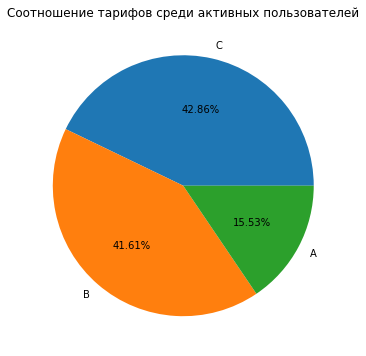

In [79]:
fig,ax = plt.subplots(figsize=(6, 6))
ax.pie(clients.query('user_id in @active_users')['tariff_plan'].value_counts(), 
       labels=clients.query('user_id in @active_users')['tariff_plan'].value_counts().index,
       autopct='%.2f%%')
ax.set_title('Соотношение тарифов среди активных пользователей')
plt.show()

Построим таблицу со всеми пользователями и распределением оптимальных тарифов среди них:

In [80]:
((comparison
 .query('user_id in @active_users')
 .groupby('tariff_plan')
 .agg({'user_id':'nunique'})
 .reset_index()
)
 .merge((comparison
         .query('user_id in @active_users')
         .groupby(['tariff_plan','optimal'])
         .agg({'user_id':'nunique'})
         .reset_index()),
        how = 'left', on = 'tariff_plan'
       ).assign(share = lambda x: round((x['user_id_y'] / x['user_id_x']*100),1))
 .rename(columns={'tariff_plan': 'current_tariff', 
                  'user_id_x': 'total_users',
                  'optimal': 'optimal_tariff',
                  'user_id_y': 'users'}))

,current_tariff,total_users,optimal_tariff,users,share
0,A,25,A,3,12.0
1,A,25,B,3,12.0
2,A,25,C,19,76.0
3,B,67,B,1,1.5
4,B,67,C,66,98.5
5,C,69,B,2,2.9
6,C,69,C,67,97.1


Построим таблицу с активными пользователями, которым выгодно сменить тариф и какой тариф им лучше выбрать:

In [81]:
((comparison
 .query('user_id in @active_users & tariff_plan != optimal')
 .groupby('tariff_plan')
 .agg({'user_id':'nunique'})
 .reset_index()
)
 .merge((comparison
         .query('user_id in @active_users  & tariff_plan != optimal')
         .groupby(['tariff_plan','optimal'])
         .agg({'user_id':'nunique'})
         .reset_index()),
        how = 'left', on = 'tariff_plan'
       )
 .rename(columns={'tariff_plan': 'current_tariff', 
                  'user_id_x': 'total_users',
                  'optimal': 'optimal_tariff',
                  'user_id_y': 'users'}))

,current_tariff,total_users,optimal_tariff,users
0,A,22,B,3
1,A,22,C,19
2,B,66,C,66
3,C,2,B,2


Почти всем пользователям выгодно перейти на тариф С

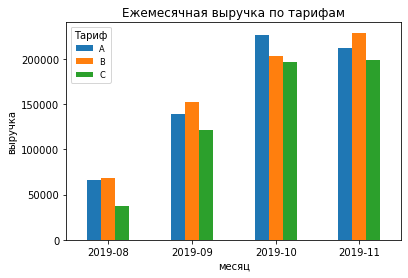

In [82]:
ax = (user_revenue
 .pivot_table(index='month',
              values='revenue',
              columns='tariff_plan',
              aggfunc='sum')
 .reset_index()
 .plot(x='month', y=['A', 'B', 'C'], kind="bar")
)
ax.set(title='Ежемесячная выручка по тарифам')
ax.set_xlabel('месяц')
ax.set_ylabel('выручка')
plt.xticks(rotation = 0)
plt.legend(title='Тариф', fontsize='small')
plt.show()

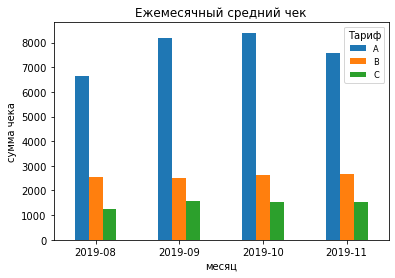

In [83]:
ax = (user_revenue
      .pivot_table(index='month',
                   columns='tariff_plan',
                   values='revenue',
                   aggfunc='mean')
      .reset_index()
      .plot(x='month', y=['A', 'B', 'C'], kind="bar"))
ax.set(title='Ежемесячный средний чек')
ax.set_xlabel('месяц')
ax.set_ylabel('сумма чека')
plt.xticks(rotation = 0)
plt.legend(title='Тариф', fontsize='small')
plt.show()

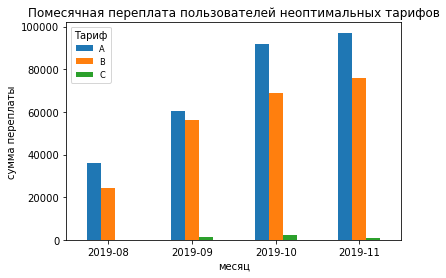

In [84]:
ax = (user_revenue
 .assign(diff = lambda x: x['revenue'] - x['optimal_revenue'])
 .pivot_table(index='month',
              columns='tariff_plan',
              values='diff',
                   aggfunc='sum')
      .reset_index()
      .plot(x='month', y=['A', 'B', 'C'], kind="bar"))
ax.set(title='Помесячная переплата пользователей неоптимальных тарифов')
ax.set_xlabel('месяц')
ax.set_ylabel('сумма переплаты')
plt.xticks(rotation = 0)
plt.legend(title='Тариф', fontsize='small')
plt.show()

Выводы по результатм исследования:
- активных пользователей больше всего среди тарифво В и С, примерно по 40%;
- для подавляющего большинства пользователей тарифов А и В, 86% и 98,5% соответсвенно, эти тарифы невыогдны;
- почти всем пользователям выгоден тариф С;
- самый высокий средний чек и самая большая переплата у пользователей тарива А.

##  Проверка статистических гипотез<a class="anchor" id="test"></a>

Для нулевой гипотезы выбриаем утверждения которые содержат в себе равенство.  
Критический уровень статистической значимости 1%, так как у нас очень большая выборка.

В двух выборках дисперсии сильно отличаются, укажем параметр equal_var равным False.  
В обоих случаях распределение не является нормальным, так как распрделение активности соответствует генеральной совокупности.

### Гипотеза 1
<b>Нулевая гипотеза:</b> Активные клиенты пользуются услугами наравне с остальными клиентами;  
<b>Альтернативная гипотеза:</b> Активные клиенты используют больший объем услуг.

In [85]:
user_revenue['active'] = False
user_revenue.loc[user_revenue['user_id'].isin(active_users), 'active'] = True
user_revenue['active'].value_counts()

True     426
False    272
Name: active, dtype: int64

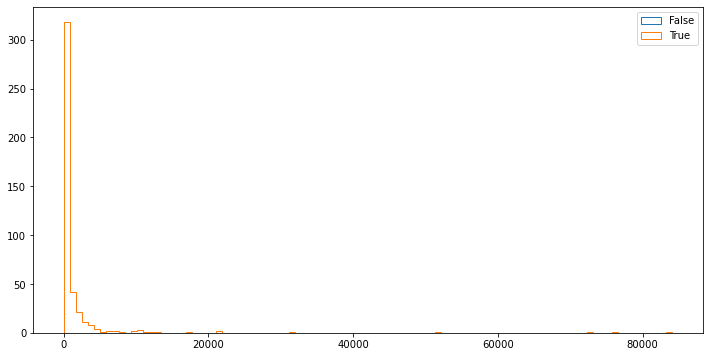

In [86]:
plt.figure(figsize=(12,6))
for active, val in user_revenue.groupby(by='active'):
    plt.hist(val['external'], histtype='step', label=active, linewidth=1, bins=100)
plt.legend()

In [87]:
user_revenue.groupby(by='active')['external'].sum()

active
False       725
True     739585
Name: external, dtype: int64

In [88]:
sample_active = user_revenue.query('user_id in @active_users')['external']
sample_other = user_revenue.query('user_id not in @active_users')['external']
alpha = .01

variance_active = np.var(sample_active)
variance_other = np.var(sample_other)
print(f'Дисперсия выборки 1: {variance_active:.2f}, дисперсия выборки 2: {variance_other:.2f}')
print()

results_active = st.ttest_ind(sample_active, sample_other, equal_var = False)

print(results_active.pvalue)
print()

if results_active.pvalue / 2 < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Дисперсия выборки 1: 54970759.40, дисперсия выборки 2: 42.08

2.0027490249380384e-06

Отвергаем нулевую гипотезу


В целом график и разброс в активности между пользователями двух групп говорит за себя. Активные пользователи намного активнее.

### Гипотеза 2
<b>Нулевая гипотеза:</b> Клиенты с неоптимальными тарифами пользуются услугами наравне с остальными</b>;  
<b>Альтернативная гипотеза:</b> Клиенты с неоптимальными тарифами пользуются услугами не наравне с остальными</b>.

In [89]:
user_revenue['optimal_flag'] = False
user_revenue.loc[user_revenue['tariff_plan'] == user_revenue['optimal'], 'optimal_flag'] = True
user_revenue['optimal_flag'].value_counts()

True     371
False    327
Name: optimal_flag, dtype: int64

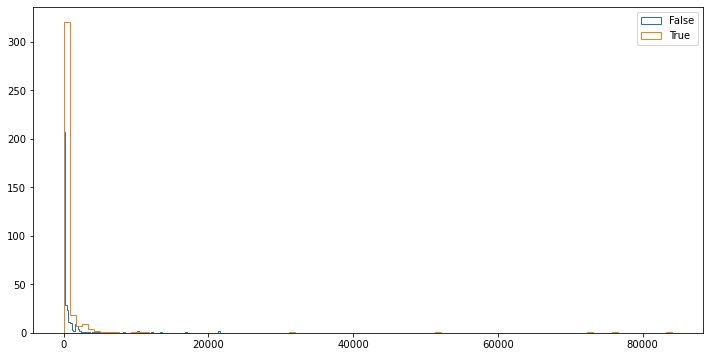

In [90]:
plt.figure(figsize=(12,6))
for optimal, val in user_revenue.groupby(by='optimal_flag'):
    plt.hist(val['external'], histtype='step', label=optimal, linewidth=1, bins=100)
plt.legend()

In [91]:
sample_optimal = comparison.query('optimal == tariff_plan')['external']
sample_not_optimal = comparison.query('optimal != tariff_plan')['external']
alpha = .01

variance_optimal = np.var(sample_optimal)
variance_not_optimal = np.var(sample_not_optimal)
print(f'Дисперсия выборки 1: {variance_optimal:.2f}, дисперсия выборки 2: {variance_not_optimal:.2f}')
print()

results_optimal = st.ttest_ind(sample_optimal, sample_not_optimal, equal_var = False)

print(results_optimal.pvalue)
print()

if results_optimal.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Дисперсия выборки 1: 325636243.81, дисперсия выборки 2: 14148775.91

0.29752204381707276

Не получилось отвергнуть нулевую гипотезу


Вторую нулевую гипотезу не получилоь отвергнуть со значительным запасом. P-значение намного выше выбранной альфы в 0.1. То есть клиенты с неоптимальными тарифами с большой вероятностью используют услуги также как и клиенты с оптимальными тарифами. Просто тариф не тот...

В случае обоих гипотез тестируем генеральные совокупности с большой разницей диспресии, поэтому при проверке гипотез указываем флаг False для equal_var.

Выводы по результатам проверки гипотез:
1. Активные клиенты используют больший объем услуг;
2. Клиенты с неоптимальными тарифами пользуются услугами наравне с остальными.

## Результат исследования<a class="anchor" id="summary"></a>

### Выводы по результатам исследования

- Всего выявлен 131 клиент с неоптимальным тарифом, из них 90 активных;
- При переходе всех активных клиентов на оптимальный тариф снижение выручки составило бы 27% или около 500 тысяч;
- Почти для всех активных клиентов более выгоден тариф С и только для 5 из них — тариф В.

В качестве предолжений для снижения потерь можно выдлить:
- Почти всем пользователем более выгоден тариф С с минимальной абонентской платой. Возможно стоит актуализировать тарифную сетку: уменьшить фиксированную сумму на более дорогих тарифах или понизить стоимость минуты;
- Возможно создание премиум тарифа для самых крупных клиентов. Таких всего несколько, но их выручка составляет очень значительную часть. Может быть её можно увеличить за счет дополнительных услуг;
- Нужно проверить уровень загруженности операторов. Изучить возможность увеличения нагрузки и привлечения новых пользователей.

Также были проверены две гипотезы и сделаны выводы:
1. Активные клиенты используют больший объем услуг;
2. Клиенты с неоптимальными тарифами пользуются услугами наравне с остальными.

### Отчет для коммерческого департамента
Список клиентов, которым целесообразно предложить переход на иной тариф:

In [92]:
(comparison
 .query('optimal != tariff_plan & user_id in @active_users')
 .reset_index(drop=True)
 .drop(['revenue_A', 'revenue_B', 'revenue_C'], axis=1)
 .rename(columns = {'tariff_plan':'current_tariff',
                    'revenue':'current_revenue',
                    'optimal': 'optimal_tariff',
                    'month': 'months_active'})).head(10)

,user_id,current_tariff,external,months_active,current_revenue,optimal_tariff,optimal_revenue
0,166377,B,6492,4,13046.0,C,10344.4
1,166405,B,16228,4,18514.0,C,17759.6
2,166406,B,7229,4,12514.5,C,9960.3
3,166407,A,424,4,22569.6,C,6696.8
4,166485,B,7529,4,13464.5,C,10970.3
5,166495,B,3260,4,10230.0,C,6882.0
6,166503,B,1204,4,9902.0,C,6142.8
7,166533,B,1444,3,7022.0,C,4310.8
8,166536,B,1520,4,9760.0,C,6064.0
9,166541,A,300,3,16020.0,C,4110.0


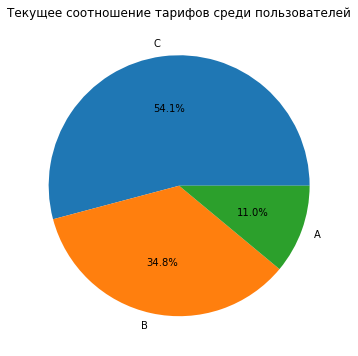

In [93]:
fig,ax = plt.subplots(figsize=(6, 6))
ax.pie(comparison['tariff_plan'].value_counts(), 
       labels=comparison['tariff_plan'].value_counts().index,
       autopct='%.1f%%')
ax.set_title('Текущее соотношение тарифов среди пользователей')
plt.show()

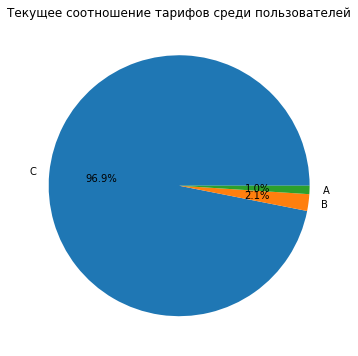

In [94]:
fig,ax = plt.subplots(figsize=(6, 6))
ax.pie(comparison['optimal'].value_counts(), 
       labels=comparison['optimal'].value_counts().index,
       autopct='%.1f%%')
ax.set_title('Текущее соотношение тарифов среди пользователей')
plt.show()

Текущие тарифы А и В практически неактуальны для клиентов. Необходимо пересмотреть тарифную сетку.

### <a href="https://disk.yandex.ru/i/orwEnhLkUPPssA">Презентация для коммерческого директора</a>

### <a href="https://public.tableau.com/app/profile/sergey5253/viz/Telecom_16606868114600/Dashboard1">Дашборд</a>